# Mini-Project for Fundamentals of Machine Learning Course

In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.


## 1. Prerequisite

This section provides some basic steps for accessing and visualizing the dataset.


In [1]:
!pip3 install scikeras[tensorflow] scikit-learn==1.4.1post1

INFO: pip is looking at multiple versions of scikeras[tensorflow] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uni

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import warnings
import multiprocessing as mp
from typing import Dict, Any
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from cuml.model_selection import GridSearchCV
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
)
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy
from keras.metrics import Precision, Recall, CategoricalAccuracy
from scikeras.wrappers import KerasClassifier
from tqdm import tqdm
from skimage import exposure, img_as_float
from skimage.feature import local_binary_pattern, hog

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [3]:
def parse_data(data: pd.DataFrame) -> tuple[np.ndarray, ...]:
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data["emotion"])))

    for i, row in tqdm(enumerate(data.index)):
        image = np.fromstring(data.loc[row, "pixels"], dtype=int, sep=" ")
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [4]:
def show_img(images: np.ndarray, labels: np.ndarray) -> None:
    """
    Visualize images and labels respectively
    """
    _, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr = axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap="gray")
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [5]:
## load dataset here
df = pd.read_csv("/kaggle/input/dataset-projectml-fer2013/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The `emotion` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.


In [6]:
## parsing data here
images, labels = parse_data(df)

35887it [00:04, 8265.42it/s]


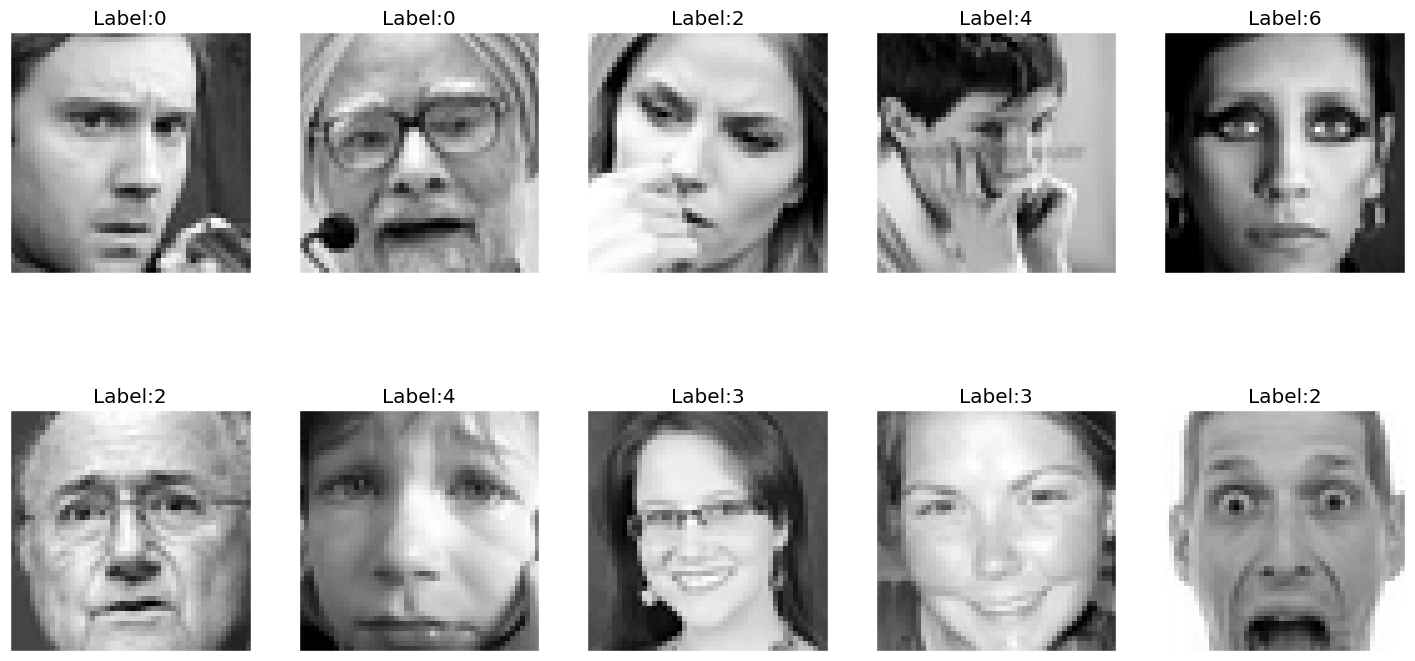

In [7]:
## showing images here
show_img(images, labels)

In [8]:
# Setup private test set for visualization
images, private_test_images, labels, private_test_labels = train_test_split(
    images, labels, test_size=0.01, random_state=42
)

private_test_labels = private_test_labels.ravel()

In [9]:
print(f"Shape of private test images: {private_test_images.shape}")
print(f"Shape of private test labels: {private_test_labels.shape}")

Shape of private test images: (359, 48, 48)
Shape of private test labels: (359,)


## 2. Prepocessing original images

### Normalizing Image


In [10]:
raw_images = images.copy()
normalized_images = images / 255.0

### Histogram Equalization


In [11]:
def plot_img_and_hist(
    image: np.ndarray[float], axes: mpl.axes.Axes, bins=256
) -> tuple[mpl.axes.Axes, ...]:
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype="step", color="black")
    ax_hist.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax_hist.set_xlabel("Pixel intensity")
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, "r")
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

Plotting an image and its histogram


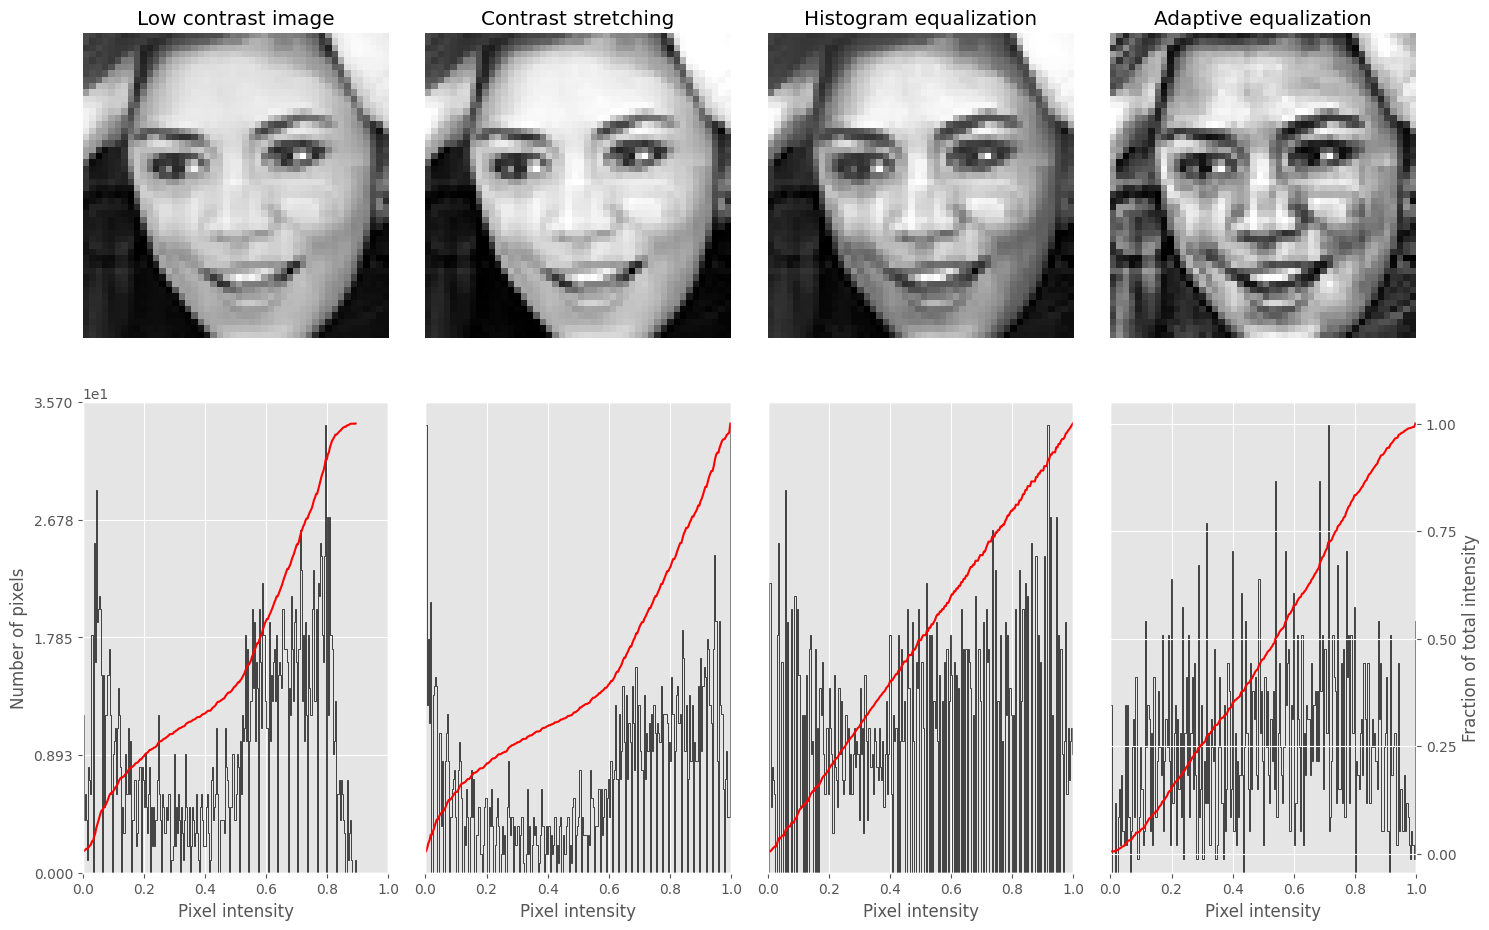

In [12]:
# Load an example image
img = normalized_images[0]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(15, 10))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1 + i, sharex=axes[0, 0], sharey=axes[0, 0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5 + i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title("Low contrast image")

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel("Number of pixels")
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title("Contrast stretching")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title("Histogram equalization")

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title("Adaptive equalization")

ax_cdf.set_ylabel("Fraction of total intensity")
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [13]:
# Apply adaptive histogram equalization
def adapteq_img(image: np.ndarray[float]) -> np.ndarray[float]:
    return exposure.equalize_adapthist(image, clip_limit=0.03)


with mp.Pool(processes=mp.cpu_count()) as pool:
    adapteq_images = np.array(
        list((tqdm(pool.imap(adapteq_img, normalized_images)))), dtype=np.float32
    )

35528it [01:28, 400.23it/s]


### Feature Extraction


In [14]:
def extract_lbp(
    image: np.ndarray[float], radius: int = 1, points: int = 8, return_lbp: bool = False
) -> tuple[np.ndarray[float], ...]:

    lbp = local_binary_pattern(image, points, radius, method="uniform")
    (hist, _) = np.histogram(
        lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2)
    )
    hist = hist.astype(np.float32)
    hist /= hist.sum() + 1e-7
    return (lbp, hist) if return_lbp else hist


def extract_hog(image: np.ndarray[float], visualize: bool = False) -> np.ndarray[float]:
    return hog(
        image,
        orientations=9,
        pixels_per_cell=(6, 6),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=visualize,
    )


def extract_features(image: np.ndarray[float]) -> np.ndarray[float]:
    assert len(image.shape) == 2
    return np.concatenate((extract_lbp(image), extract_hog(image)))

In [15]:
def visulize_lbp(
    image: np.ndarray[float], lbp: np.ndarray[float], hist: np.ndarray[float]
) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

    # Visualize original image
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Visualize LBP
    ax[1].imshow(lbp, cmap="gray")
    ax[1].set_title("LBP Image")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    # Display the HOG features
    ax[2].bar(np.arange(len(hist)), hist, width=0.6, color="gray")
    ax[2].set_title("LBP Historgram")
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    return


def visulize_hog(image: np.ndarray[float], hog_image: np.ndarray[float]) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Visualize original image
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Visualize HOG
    ax[1].imshow(hog_image_rescaled, cmap="gray")
    ax[1].set_title("HOG Image")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    return

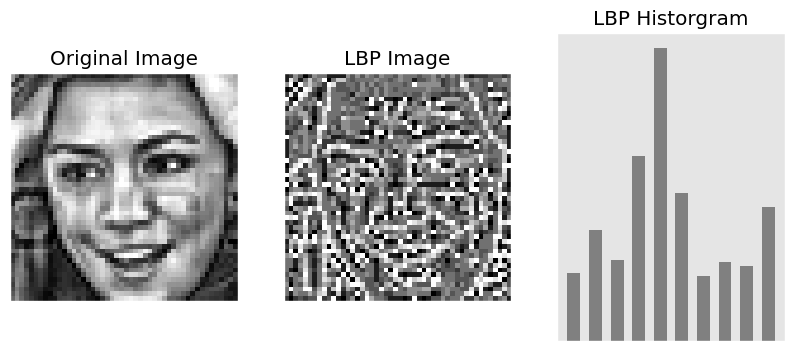

In [16]:
img = adapteq_images[0]

# Visualize LBP result
visulize_lbp(img, *extract_lbp(img, return_lbp=True))

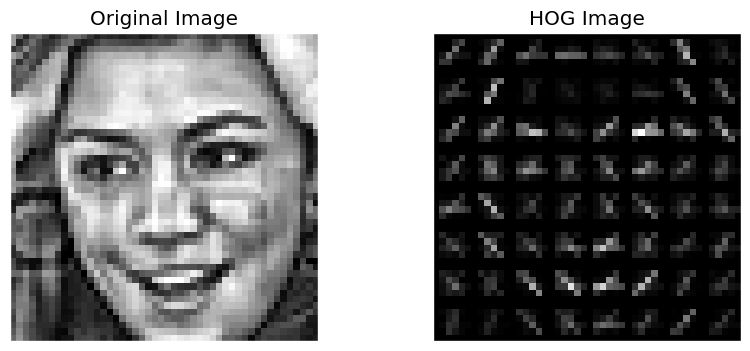

In [17]:
# Visualize HOG result
visulize_hog(img, extract_hog(img, visualize=True)[-1])

In [18]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    features = np.array(
        list(tqdm(pool.imap(extract_features, adapteq_images))), dtype=np.float32
    )

35528it [01:04, 552.34it/s]


## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)


In [19]:
# Apply PCA with 2 principal components
pca_2_components = PCA(n_components=2)
pca_features = pca_2_components.fit_transform(features)
pca_features.shape

(35528, 2)

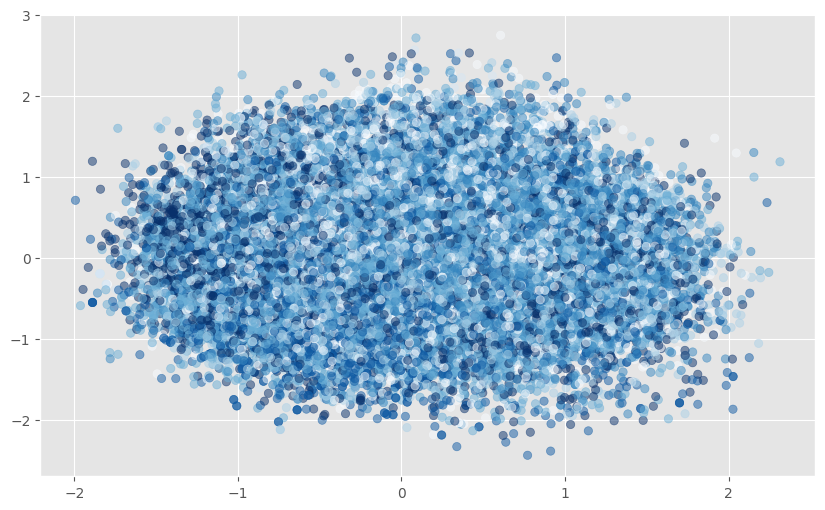

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(x=pca_features[:, 0], y=pca_features[:, 1], c=labels, alpha=0.5, cmap='Blues')

#### Question 2: How to determine the optimal number of principal components using `pca.explained_variance_`? Explain your selection process. (2 points)


In [21]:
pca_full = PCA()
pca_full.fit(features)

PCA()

In [22]:
## determine the optimal number of PCs here
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f"{features.shape=}")
_ = [
    print(
        f"{np.min(np.where(cumulative_explained_variance >= percent)[0] + 1)} PCs explain {percent}% of the variance"
    )
    for percent in [0.9, 0.95, 0.98, 0.99]
]

features.shape=(35528, 1774)
397 PCs explain 0.9% of the variance
484 PCs explain 0.95% of the variance
566 PCs explain 0.98% of the variance
736 PCs explain 0.99% of the variance


Plot the cumulative explained variance by number of principal components


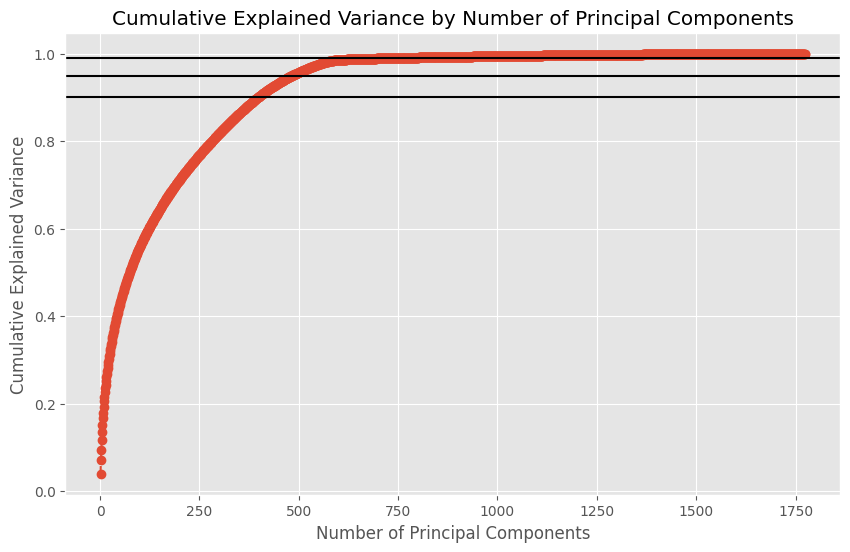

In [23]:
plt.figure(figsize=(10, 6))

# Plot the cumulative explained variance against the number of principal components
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",  # marker style
    linestyle="--",  # line style
)

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Number of Principal Components")
[plt.axhline(y=y, color="black") for y in [0.9, 0.95, 0.99]]
plt.grid(True)
plt.show()

Plot the difference in cumulative explained variance by number of principal components


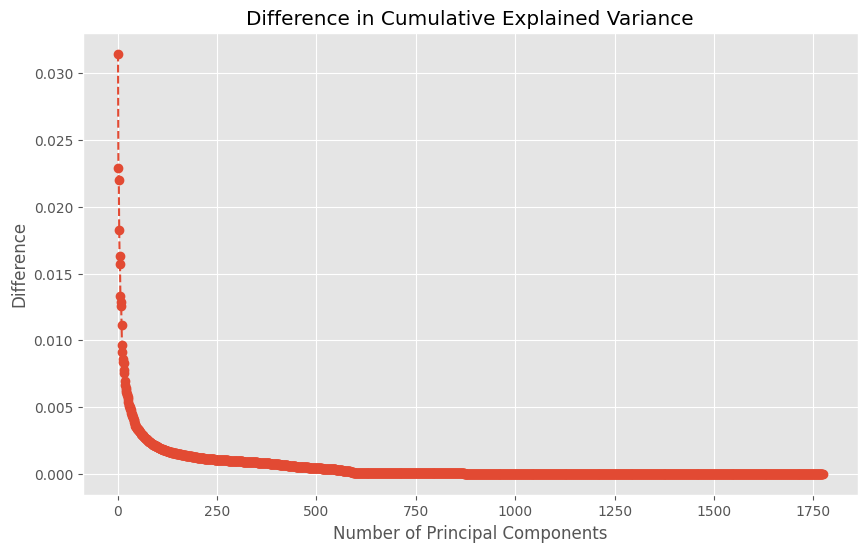

In [24]:
plt.figure(figsize=(10, 6))

# Plot the difference in cumulative explained variance against the number of principal components
plt.plot(
    range(1, len(cumulative_explained_variance)),
    np.diff(cumulative_explained_variance),
    marker="o",  # marker style
    linestyle="--",  # line style
)

plt.xlabel("Number of Principal Components")
plt.ylabel("Difference")
plt.title("Difference in Cumulative Explained Variance")
plt.grid(True)
plt.show()

Dựa vào 2 hình vẽ ở trên

1. Số lượng thông tin của dữ liệu dựa trên số PCs
2. Hiệu của hai giá trị thông tin liền kề nhau

và mục đích là huấn luyện được mô hình có khả năng dự đoán tốt nhất.

Suy ra, ta sẽ chọn giữ lại nhiều thông tin nhất có thể của một bức ảnh, nên ta sẽ chọn giữ lại 736 PCs (tương ứng với 99% thông tin từ features). Từ đó, ta loại bỏ đi 1041 (1775 - 736) PCs chứa lượng thông tin thấp nhất


In [25]:
origin_data = features

# Fit PCA and transform the data
pca_main = PCA(n_components=0.99)
transformed_data = pca_main.fit_transform(features)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using `GridSearchCV` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html


### Spliting Data to Train and Test


In [26]:
origin_X_train, origin_X_test, origin_y_train, origin_y_test = train_test_split(
    origin_data, labels, test_size=0.2, random_state=42
)

transformed_X_train, transformed_X_test, transformed_y_train, transformed_y_test = (
    train_test_split(transformed_data, labels, test_size=0.2, random_state=42)
)

origin_y_train = origin_y_train.ravel()
origin_y_test = origin_y_test.ravel()
transformed_y_train = transformed_y_train.ravel()
transformed_y_test = transformed_y_test.ravel()

num_classes = np.unique(origin_y_train).shape[0]

In [27]:
_ = [
    print(f"{key}: {value.shape}")
    for key, value in {
        "Shape of Original training data": origin_X_train,
        "Shape of Original testing data": origin_X_test,
        "Shape of Original training target": origin_y_train,
        "Shape of Original testing target": origin_y_test,
        "Shape of Transformed training data": transformed_X_train,
        "Shape of Transformed testing data": transformed_X_test,
        "Shape of Transformed training target": transformed_y_train,
        "Shape of Transformed testing target": transformed_y_test,
    }.items()
]

Shape of Original training data: (28422, 1774)
Shape of Original testing data: (7106, 1774)
Shape of Original training target: (28422,)
Shape of Original testing target: (7106,)
Shape of Transformed training data: (28422, 736)
Shape of Transformed testing data: (7106, 736)
Shape of Transformed training target: (28422,)
Shape of Transformed testing target: (7106,)


### 3.1. SVM

---


In [ ]:
# Define parameter grid
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf", "poly"],
    "gamma": ["scale", "auto"],

}
scorer = make_scorer(f1_score, average="micro")
1
# Initialize GridSearchCV with SVC estimator
grid_search = GridSearchCV(
    estimator=SVC(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer
)

# Fit GridSearchCV with training data
grid_search.fit(origin_X_train, origin_y_train)

In [29]:
# Best parameters and model
origin_svc_params = grid_search.best_params_
origin_svc_model = grid_search.best_estimator_

print("Best Parameters:", origin_svc_params)
print("Best Model:", origin_svc_model)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Model: SVC()


In [30]:
# Extract the results
cv_results = grid_search.cv_results_

# Extract timing information
mean_fit_times = cv_results['mean_fit_time']
mean_score_times = cv_results['mean_score_time']
param_combinations = cv_results['params']

# Print the timing information for each candidate
for i, params in enumerate(param_combinations):
    print(f"Parameters: {params}")
    print(f"Mean Fit Time: {mean_fit_times[i]:.4f} seconds")
    print(f"Mean Score Time: {mean_score_times[i]:.4f} seconds")
    print("-" * 30)

Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Fit Time: 16.4939 seconds
Mean Score Time: 4.7993 seconds
------------------------------
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Fit Time: 16.6619 seconds
Mean Score Time: 3.9257 seconds
------------------------------
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Fit Time: 9.6552 seconds
Mean Score Time: 3.0788 seconds
------------------------------
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Mean Fit Time: 11.3948 seconds
Mean Score Time: 4.9742 seconds
------------------------------
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Fit Time: 14.4987 seconds
Mean Score Time: 2.7365 seconds
------------------------------
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Fit Time: 35.5453 seconds
Mean Score Time: 3.3730 seconds
------------------------------
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Fit Time: 11.1277 seconds
Mean S

In [31]:
origin_svc_preds = grid_search.best_estimator_.predict(origin_X_test)

print(f"Precision Score: {precision_score(origin_y_test, origin_svc_preds, average='micro')}")
print(f"Recall Score: {recall_score(origin_y_test, origin_svc_preds, average='micro')}")
print(f"F1 Score: {f1_score(origin_y_test, origin_svc_preds, average='micro')}")

Precision Score: 0.5399662257247396
Recall Score: 0.5399662257247396
F1 Score: 0.5399662257247396


In [ ]:
# Define parameter grid
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf", "poly"],
    "gamma": ["scale", "auto"],
}
scorer = make_scorer(f1_score, average="micro")

# Initialize GridSearchCV with SVC estimator
grid_search = GridSearchCV(
    estimator=SVC(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, scoring=scorer
)

# Fit GridSearchCV with training data
grid_search.fit(transformed_X_train, transformed_y_train)

In [33]:
# Best parameters and model
transform_svc_params = grid_search.best_params_
transform_svc_model = grid_search.best_estimator_

print("Best Parameters:", transform_svc_params)
print("Best Model:", transform_svc_model)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Model: SVC()


In [34]:
# Extract the results
cv_results = grid_search.cv_results_

# Extract timing information
mean_fit_times = cv_results['mean_fit_time']
mean_score_times = cv_results['mean_score_time']
param_combinations = cv_results['params']

# Print the timing information for each candidate
for i, params in enumerate(param_combinations):
    print(f"Parameters: {params}")
    print(f"Mean Fit Time: {mean_fit_times[i]:.4f} seconds")
    print(f"Mean Score Time: {mean_score_times[i]:.4f} seconds")
    print("-" * 30)

Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Fit Time: 5.7404 seconds
Mean Score Time: 2.9346 seconds
------------------------------
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Fit Time: 10.0819 seconds
Mean Score Time: 5.7878 seconds
------------------------------
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Fit Time: 8.6543 seconds
Mean Score Time: 2.2650 seconds
------------------------------
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Mean Fit Time: 6.5659 seconds
Mean Score Time: 5.1434 seconds
------------------------------
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Fit Time: 8.1344 seconds
Mean Score Time: 1.5701 seconds
------------------------------
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Fit Time: 14.9894 seconds
Mean Score Time: 5.1828 seconds
------------------------------
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Fit Time: 9.1052 seconds
Mean Score

In [35]:
transform_svc_preds = grid_search.best_estimator_.predict(transformed_X_test)

print(f"Precision Score: {precision_score(transformed_y_test, transform_svc_preds, average='micro')}")
print(f"Recall Score: {recall_score(transformed_y_test, transform_svc_preds, average='micro')}")
print(f"F1 Score: {f1_score(transformed_y_test, transform_svc_preds, average='micro')}")

Precision Score: 0.5427807486631016
Recall Score: 0.5427807486631016
F1 Score: 0.5427807486631016


### 3.2. XGBoost

---


In [36]:
def XGB(X, y):
    """
    Train Model XGBoost
    X,y: data train
    """
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [7, 9],
    }
    scorer = make_scorer(f1_score, average="micro")

    """
    learning_rate: The learning rate of the model. Smaller values lead to slower learning but can help the model find a better solution.

    n_estimators: The number of decision trees in the model. Larger values lead to a more complex model but can help the model learn better from the data.

    max_depth: The maximum depth of each decision tree. Larger values lead to more complex decision trees but can lead to overfitting.

    gamma: A parameter that controls the complexity of the model. Larger values lead to a simpler model but can limit the model's ability to learn.

    reg_lambda: A parameter that adjusts the amount of L2 regularization. Larger values lead to a simpler model but can help reduce overfitting.
    """

    model = GridSearchCV(XGBClassifier(device="cuda"), param_grid=param_grid, scoring=scorer)
    model.fit(X, y)
    return model

In [ ]:
# Train Model XGBoost for origin data
origin_xgb_model = XGB(origin_X_train, origin_y_train)
origin_xgb_preds = origin_xgb_model.predict(origin_X_test)

In [38]:
# Extract the results
cv_results = origin_xgb_model.cv_results_

# Extract timing information
mean_fit_times = cv_results['mean_fit_time']
mean_score_times = cv_results['mean_score_time']
param_combinations = cv_results['params']

# Print the timing information for each candidate
for i, params in enumerate(param_combinations):
    print(f"Parameters: {params}")
    print(f"Mean Fit Time: {mean_fit_times[i]:.4f} seconds")
    print(f"Mean Score Time: {mean_score_times[i]:.4f} seconds")
    print("-" * 30)

Parameters: {'max_depth': 7, 'n_estimators': 100}
Mean Fit Time: 61.2026 seconds
Mean Score Time: 0.1568 seconds
------------------------------
Parameters: {'max_depth': 7, 'n_estimators': 200}
Mean Fit Time: 102.1441 seconds
Mean Score Time: 0.1920 seconds
------------------------------
Parameters: {'max_depth': 9, 'n_estimators': 100}
Mean Fit Time: 111.0741 seconds
Mean Score Time: 0.1601 seconds
------------------------------
Parameters: {'max_depth': 9, 'n_estimators': 200}
Mean Fit Time: 156.8667 seconds
Mean Score Time: 0.1740 seconds
------------------------------


In [39]:
print("Accuracy: ", accuracy_score(origin_y_test, origin_xgb_preds))
print("Precision: ", precision_score(origin_y_test, origin_xgb_preds, average="micro"))
print("Recall: ", recall_score(origin_y_test, origin_xgb_preds, average="micro"))
print("F1: ", f1_score(origin_y_test, origin_xgb_preds, average="micro"))

Accuracy:  0.5016887137630172
Precision:  0.5016887137630172
Recall:  0.5016887137630172
F1:  0.5016887137630172


In [40]:
transform_xgb_model = XGB(transformed_X_train, transformed_y_train)
transform_xgb_preds = transform_xgb_model.predict(transformed_X_test)

In [41]:
# Extract the results
cv_results = transform_xgb_model.cv_results_

# Extract timing information
mean_fit_times = cv_results['mean_fit_time']
mean_score_times = cv_results['mean_score_time']
param_combinations = cv_results['params']

# Print the timing information for each candidate
for i, params in enumerate(param_combinations):
    print(f"Parameters: {params}")
    print(f"Mean Fit Time: {mean_fit_times[i]:.4f} seconds")
    print(f"Mean Score Time: {mean_score_times[i]:.4f} seconds")
    print("-" * 30)

Parameters: {'max_depth': 7, 'n_estimators': 100}
Mean Fit Time: 25.8771 seconds
Mean Score Time: 0.0811 seconds
------------------------------
Parameters: {'max_depth': 7, 'n_estimators': 200}
Mean Fit Time: 44.6051 seconds
Mean Score Time: 0.1006 seconds
------------------------------
Parameters: {'max_depth': 9, 'n_estimators': 100}
Mean Fit Time: 48.3098 seconds
Mean Score Time: 0.0834 seconds
------------------------------
Parameters: {'max_depth': 9, 'n_estimators': 200}
Mean Fit Time: 69.2594 seconds
Mean Score Time: 0.1071 seconds
------------------------------


In [42]:
print("Accuracy: ", accuracy_score(transformed_y_test, transform_xgb_preds))
print(
    "Precision: ",
    precision_score(transformed_y_test, transform_xgb_preds, average="micro"),
)
print(
    "Recall: ",
    recall_score(transformed_y_test, transform_xgb_preds, average="micro"),
)
print("F1: ", f1_score(transformed_y_test, transform_xgb_preds, average="micro"))

Accuracy:  0.46692935547424713
Precision:  0.46692935547424713
Recall:  0.46692935547424713
F1:  0.46692935547424713


### 3.3. Logistic Regression

---


In [43]:
def build_model_logistic_regression(X_train, y_train):

    # Define the parameter grid
    logreg = LogisticRegression(max_iter=2_200)

    # Define the parameter grid
    param_grid = {
        "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
        "penalty": [
            "l2",
            "l1",
        ],  # Regularization type (note: 'saga' solver supports both)
    }

    # Define the scorer for GridSearchCV
    scorer = make_scorer(f1_score, average="micro")

    # Perform grid search
    grid_search = GridSearchCV(
        estimator=logreg, param_grid=param_grid, scoring=scorer, cv=3, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    # Train the model with the best parameters
    best_model = grid_search.best_estimator_
    
    # Extract the results
    cv_results = grid_search.cv_results_

    # Extract timing information
    mean_fit_times = cv_results['mean_fit_time']
    mean_score_times = cv_results['mean_score_time']
    param_combinations = cv_results['params']

    # Print the timing information for each candidate
    for i, params in enumerate(param_combinations):
        print(f"Parameters: {params}")
        print(f"Mean Fit Time: {mean_fit_times[i]:.4f} seconds")
        print(f"Mean Score Time: {mean_score_times[i]:.4f} seconds")
        print("-" * 30)

    return best_model

In [44]:
# Get the best model of Logistic
origin_logreg_model = build_model_logistic_regression(origin_X_train, origin_y_train)

/opt/conda/lib/python3.10/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()
/opt/conda/lib/python3.10/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()
/opt/conda/lib/python3.10/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()
/opt/conda/lib/python3.10/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved

[W] [19:45:20.899646] QWL-QN: max iterations reached
[W] [19:45:20.900160] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Best parameters found: {'C': 1, 'penalty': 'l1'}
Parameters: {'C': 0.01, 'penalty': 'l2'}
Mean Fit Time: 140.5104 seconds
Mean Score Time: 0.1267 seconds
------------------------------
Parameters: {'C': 0.01, 'penalty': 'l1'}
Mean Fit Time: 48.6378 seconds
Mean Score Time: 0.0689 seconds
------------------------------
Parameters: {'C': 0.1, 'penalty': 'l2'}
Mean Fit Time: 4.8447 seconds
Mean Score Time: 0.0367 seconds
------------------------------
Parameters: {'C': 0.1, 'penalty': 'l1'}
Mean Fit Time: 17.9081 seconds
Mean Score Time: 0.0377 seconds
------------------------------
Parameters: {'C': 1, 'penalty': 'l2'}
Mean Fit Time: 7.7965 seconds
Mean Score Time: 0.0356 seconds
------------------------------
Parameters: {'C': 1, 'penalty'

In [45]:
# Make predictions on the test set
origin_logreg_preds = origin_logreg_model.predict(origin_X_test)

# Evaluate the model
# Since it's multi-class, we use average='macro' to account for class imbalance
print("Accuracy: ", accuracy_score(origin_y_test, origin_logreg_preds))
print(
    "Precision: ", precision_score(origin_y_test, origin_logreg_preds, average="micro")
)
print("Recall: ", recall_score(origin_y_test, origin_logreg_preds, average="micro"))
print("F1: ", f1_score(origin_y_test, origin_logreg_preds, average="micro"))

Accuracy:  0.4382212215029552
Precision:  0.4382212215029552
Recall:  0.4382212215029552
F1:  0.4382212215029552


In [46]:
# Get the best model of Logistic
transform_logreg_model = build_model_logistic_regression(
    transformed_X_train, transformed_y_train
)

Best parameters found: {'C': 1, 'penalty': 'l1'}
Parameters: {'C': 0.01, 'penalty': 'l2'}
Mean Fit Time: 0.2646 seconds
Mean Score Time: 0.0458 seconds
------------------------------
Parameters: {'C': 0.01, 'penalty': 'l1'}
Mean Fit Time: 0.5706 seconds
Mean Score Time: 0.0309 seconds
------------------------------
Parameters: {'C': 0.1, 'penalty': 'l2'}
Mean Fit Time: 0.5018 seconds
Mean Score Time: 0.0243 seconds
------------------------------
Parameters: {'C': 0.1, 'penalty': 'l1'}
Mean Fit Time: 0.7573 seconds
Mean Score Time: 0.0237 seconds
------------------------------
Parameters: {'C': 1, 'penalty': 'l2'}
Mean Fit Time: 0.9547 seconds
Mean Score Time: 0.0304 seconds
------------------------------
Parameters: {'C': 1, 'penalty': 'l1'}
Mean Fit Time: 0.4269 seconds
Mean Score Time: 0.0258 seconds
------------------------------
Parameters: {'C': 10, 'penalty': 'l2'}
Mean Fit Time: 1.5593 seconds
Mean Score Time: 0.0220 seconds
------------------------------
Parameters: {'C': 10, '

In [47]:
# Make predictions on the test set
transform_logreg_preds = transform_logreg_model.predict(transformed_X_test)

# Evaluate the model
# Since it's multi-class, we use average='macro' to account for class imbalance
print("Accuracy: ", accuracy_score(transformed_y_test, transform_logreg_preds))
print(
    "Precision: ",
    precision_score(transformed_y_test, transform_logreg_preds, average="micro"),
)
print(
    "Recall: ",
    recall_score(transformed_y_test, transform_logreg_preds, average="micro"),
)
print("F1: ", f1_score(transformed_y_test, transform_logreg_preds, average="micro"))

Accuracy:  0.4355474247115114
Precision:  0.4355474247115114
Recall:  0.4355474247115114
F1:  0.4355474247115114


### 3.4. MLP

---


In [48]:
# Set params for GridSearchCV
dropout_rate = [0.2, 0.5]
dense_units = [(256, 128)]
learning_rate = [0.001, 0.01]

param_grid = dict(
    model__dropout_rate=dropout_rate,
    model__dense_units=dense_units,
    optimizer__learning_rate=learning_rate,
)

onehot_origin_y_train = to_categorical(origin_y_train)
onehot_origin_y_test = to_categorical(origin_y_test)
onehot_transformed_y_train = to_categorical(transformed_y_train)
onehot_transformed_y_test = to_categorical(transformed_y_test)

In [49]:
def create_MLP_model_for_origin(
    dense_units: tuple[int, int], dropout_rate: float, meta: Dict[str, Any]
) -> Sequential:
    global num_classes, origin_X_train
    model = Sequential(
        [
            Input(shape=(origin_X_train.shape[1],)),
            Dense(dense_units[0], activation="relu"),
            BatchNormalization(),
            Dense(dense_units[1], activation="relu"),
            BatchNormalization(),
            Dropout(dropout_rate),
        ],
    )
    if meta["target_type_"] == "binary":
        n_output_units = 1
        output_activation = "sigmoid"
        loss = "binary_crossentropy"
    elif meta["target_type_"] == "multiclass":
        n_output_units = meta["n_classes_"]
        output_activation = "softmax"
        loss = "sparse_categorical_crossentropy"
    else:
        raise NotImplementedError(f"Unsupported task type: {meta['target_type_']}")
    model.add(Dense(n_output_units, activation=output_activation))
    model.compile(loss=loss)
    return model


def create_MLP_model_for_transform(
    dense_units: tuple[int, int], dropout_rate: float, meta: Dict[str, Any]
) -> Sequential:
    global num_classes, origin_X_train
    model = Sequential(
        [
            Input(shape=(transformed_X_train.shape[1],)),
            Dense(dense_units[0], activation="relu"),
            BatchNormalization(),
            Dense(dense_units[1], activation="relu"),
            BatchNormalization(),
            Dropout(dropout_rate),
        ],
    )
    if meta["target_type_"] == "binary":
        n_output_units = 1
        output_activation = "sigmoid"
        loss = "binary_crossentropy"
    elif meta["target_type_"] == "multiclass":
        n_output_units = meta["n_classes_"]
        output_activation = "softmax"
        loss = "sparse_categorical_crossentropy"
    else:
        raise NotImplementedError(f"Unsupported task type: {meta['target_type_']}")
    model.add(Dense(n_output_units, activation=output_activation))
    model.compile(loss=loss)
    return model


mlp_model = [
    KerasClassifier(
        model=function,
        validation_split=0.2,
        optimizer="Adam",
        loss="sparse_categorical_crossentropy",
        metrics=[
            CategoricalAccuracy(name="accuracy"),
            Precision(name="pre"),
            Recall(name="recall"),
        ],
        batch_size=32,
        epochs=15,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0,
    )
    for function in [create_MLP_model_for_origin, create_MLP_model_for_transform]
]

scorer = make_scorer(f1_score, average="micro")
mlp_gridsearch = [
    GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=5,
    )
    for model in mlp_model
]

In [50]:
for model, X_train, y_train in zip(
    mlp_gridsearch,
    [origin_X_train, transformed_X_train],
    [origin_y_train, transformed_y_train],
):
    model.fit(X_train, y_train)
    print(f"Best: {model.best_score_} using {model.best_params_}")    
    
    # Extract the results
    cv_results = model.cv_results_

    # Extract timing information
    mean_fit_times = cv_results['mean_fit_time']
    mean_score_times = cv_results['mean_score_time']
    param_combinations = cv_results['params']

    # Print the timing information for each candidate
    for i, params in enumerate(param_combinations):
        print(f"Parameters: {params}")
        print(f"Mean Fit Time: {mean_fit_times[i]:.4f} seconds")
        print(f"Mean Score Time: {mean_score_times[i]:.4f} seconds")
        print("-" * 30)


[W] [19:43:34.846591] QWL-QN line search failed (code 3); stopping at the last valid step
[W] [19:44:43.963751] QWL-QN: max iterations reached
[W] [19:44:43.964912] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [19:45:09.626126] QWL-QN: max iterations reached
[W] [19:45:09.626555] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [19:45:23.708493] QWL-QN line search failed (code 3); stopping at the last valid step
[W] [19:44:10.175769] QWL-QN: max iterations reached
[W] [19:44:10.177006] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [19:44:41.347804] QWL-QN: max iterations reached
[W] [19:44:

In [51]:
origin_mlp_model = mlp_gridsearch[0].best_estimator_
origin_mlp_preds = origin_mlp_model.predict(origin_X_test)

In [52]:
print("Accuracy: ", accuracy_score(origin_y_test, origin_mlp_preds))
print("Precision: ", precision_score(origin_y_test, origin_mlp_preds, average="micro"))
print("Recall: ", recall_score(origin_y_test, origin_mlp_preds, average="micro"))
print("F1: ", f1_score(origin_y_test, origin_mlp_preds, average="micro"))

Accuracy:  0.4577821559245708
Precision:  0.4577821559245708
Recall:  0.4577821559245708
F1:  0.4577821559245708


In [53]:
transform_mlp_model = mlp_gridsearch[-1].best_estimator_
transform_mlp_preds = transform_mlp_model.predict(transformed_X_test)

In [54]:
print("Accuracy: ", accuracy_score(transformed_y_test, transform_mlp_preds))
print(
    "Precision: ",
    precision_score(transformed_y_test, transform_mlp_preds, average="micro"),
)
print(
    "Recall: ", recall_score(transformed_y_test, transform_mlp_preds, average="micro")
)
print("F1: ", f1_score(transformed_y_test, transform_mlp_preds, average="micro"))

Accuracy:  0.45004221784407544
Precision:  0.45004221784407544
Recall:  0.45004221784407544
F1:  0.45004221784407544


## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)


Như đề bài đã đề cập, ta sẽ sử dụng classification_report và confusion_matrix để xác định xem đâu là model tốt nhất trong 4 model và tại sao. Đồng thời, xác định luôn đây là emotion (label) được đoán đúng nhất và được đoán sai nhất 

### Classification Report and Confusion Matrix


In [55]:
def visualize_confusion_matrix(y_test: np.ndarray, pred: np.ndarray, name_model: str) -> None:
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion matrix of {name_model}')
    plt.show()

_____MLP_____
              precision    recall  f1-score   support

           0       0.36      0.33      0.35      1005
           1       0.64      0.16      0.26       129
           2       0.30      0.30      0.30      1000
           3       0.59      0.76      0.66      1755
           4       0.35      0.30      0.32      1212
           5       0.53      0.60      0.57       776
           6       0.45      0.35      0.39      1229

    accuracy                           0.46      7106
   macro avg       0.46      0.40      0.41      7106
weighted avg       0.45      0.46      0.44      7106



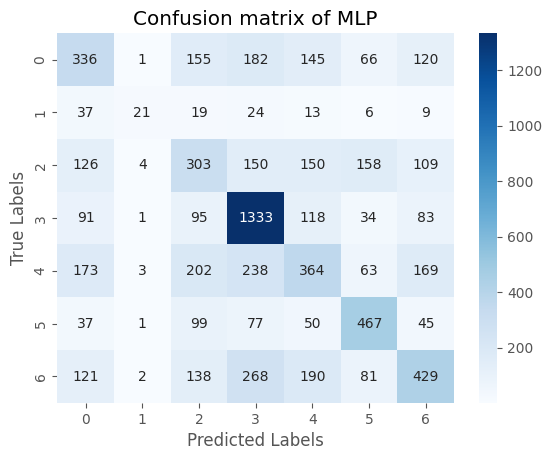

_____XGB_____
              precision    recall  f1-score   support

           0       0.44      0.34      0.38      1005
           1       1.00      0.25      0.40       129
           2       0.42      0.32      0.36      1000
           3       0.60      0.77      0.67      1755
           4       0.37      0.40      0.38      1212
           5       0.73      0.59      0.65       776
           6       0.44      0.48      0.46      1229

    accuracy                           0.50      7106
   macro avg       0.57      0.45      0.47      7106
weighted avg       0.50      0.50      0.49      7106



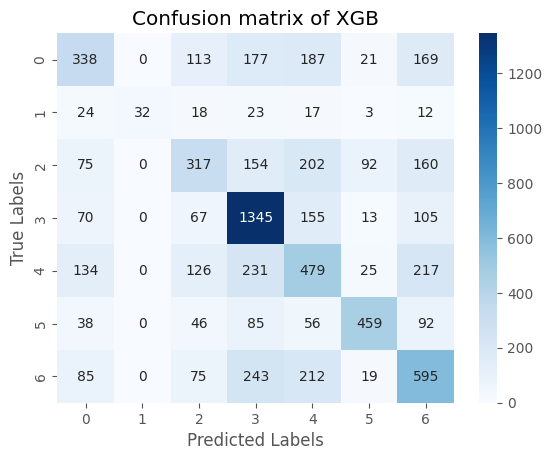

_____Logistic_____
              precision    recall  f1-score   support

           0       0.35      0.30      0.32      1005
           1       0.49      0.17      0.25       129
           2       0.32      0.25      0.28      1000
           3       0.56      0.71      0.63      1755
           4       0.31      0.30      0.30      1212
           5       0.52      0.56      0.54       776
           6       0.40      0.41      0.40      1229

    accuracy                           0.44      7106
   macro avg       0.42      0.38      0.39      7106
weighted avg       0.42      0.44      0.43      7106



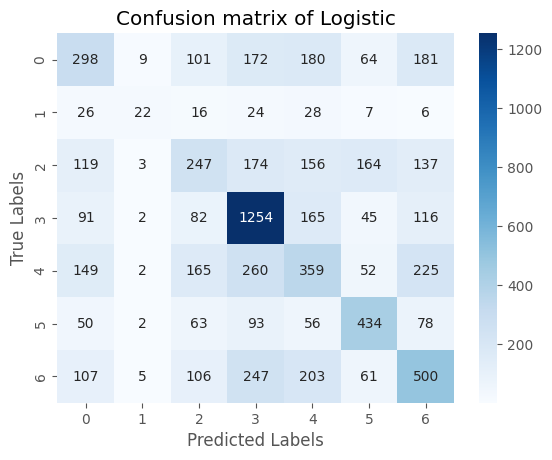

_____SVC_____
              precision    recall  f1-score   support

           0       0.46      0.39      0.42      1005
           1       0.90      0.36      0.51       129
           2       0.44      0.41      0.42      1000
           3       0.68      0.75      0.72      1755
           4       0.40      0.46      0.43      1212
           5       0.71      0.68      0.70       776
           6       0.48      0.47      0.48      1229

    accuracy                           0.54      7106
   macro avg       0.58      0.50      0.53      7106
weighted avg       0.54      0.54      0.54      7106



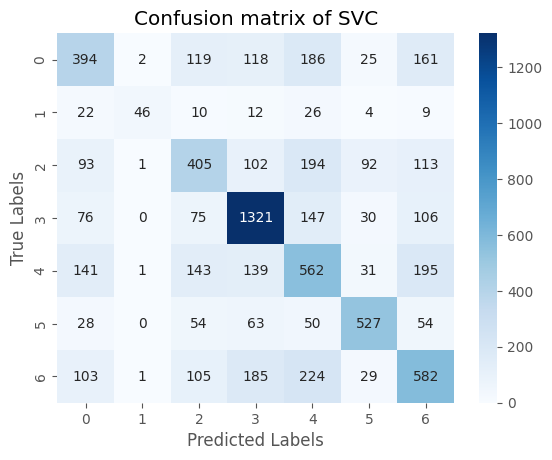

In [56]:
## visualize the confusion matrices and classification reports here
origin_preds = {
    'MLP': origin_mlp_preds,
    'XGB': origin_xgb_preds,
    'Logistic': origin_logreg_preds,
    'SVC': origin_svc_preds,
}
# Report of origin predictions
for name, preds in origin_preds.items():
    print(f'_____{name}_____')
    print(classification_report(origin_y_test, preds))
    visualize_confusion_matrix(origin_y_test, preds, name)

1. Dựa vào thông số của classification_report của 4 model đối với Original Data, ta có thể thấy F1-Score của SVC là cao nhất, và có sự đồng đều nhất trong cả 4. Nên là SVC sẽ model tốt nhất

2. Về phần xác định emotion có most accuracies và most erros, có nhiều cách để xác định:
    - Nếu xét về tỉ lệ giữa giá trị trên đường chéo chính và tổng giá trị ở từng cột: 
        - Most accuracies: 3 (Happy)
        - Most errors: 1 (Disgust)
    
    - Nếu xét về mặt số lượng (phù hợp hơn với imbalance data), label có most accuracies là label có giá trị đường chéo chính cao nhất, label có most errors là label có tổng cột trừ đường chéo chính cao nhất
        - Most accuracies: 3 (Happy)
        - Most errors: 4 (Sad)

    Đối với dữ liệu này ta sẽ thiên về kết quả xét từ mặt số lượng, nên label đoán đúng nhất là Happy và label đoán sai nhất là Sad

_____MLP_____
              precision    recall  f1-score   support

           0       0.38      0.29      0.33      1005
           1       0.83      0.08      0.14       129
           2       0.33      0.23      0.27      1000
           3       0.61      0.70      0.66      1755
           4       0.32      0.44      0.37      1212
           5       0.55      0.57      0.56       776
           6       0.40      0.38      0.39      1229

    accuracy                           0.45      7106
   macro avg       0.49      0.38      0.39      7106
weighted avg       0.45      0.45      0.44      7106



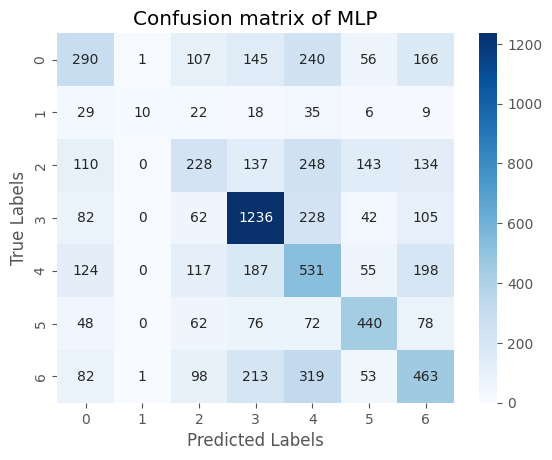

_____XGB_____
              precision    recall  f1-score   support

           0       0.43      0.29      0.35      1005
           1       1.00      0.23      0.38       129
           2       0.39      0.29      0.33      1000
           3       0.55      0.76      0.64      1755
           4       0.33      0.37      0.35      1212
           5       0.72      0.53      0.61       776
           6       0.39      0.41      0.40      1229

    accuracy                           0.47      7106
   macro avg       0.54      0.41      0.44      7106
weighted avg       0.47      0.47      0.46      7106



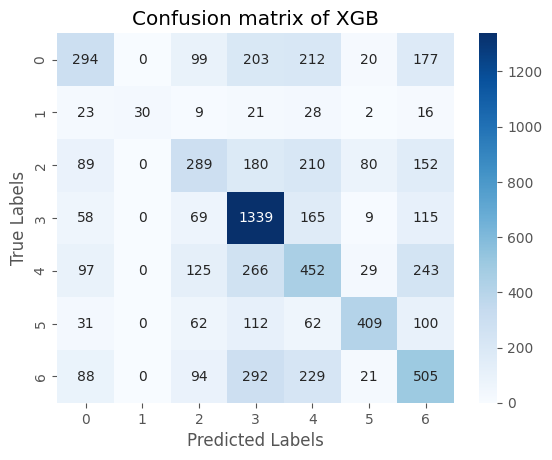

_____Logistic_____
              precision    recall  f1-score   support

           0       0.35      0.29      0.32      1005
           1       0.42      0.16      0.23       129
           2       0.31      0.25      0.28      1000
           3       0.56      0.72      0.63      1755
           4       0.31      0.29      0.30      1212
           5       0.52      0.55      0.54       776
           6       0.40      0.40      0.40      1229

    accuracy                           0.44      7106
   macro avg       0.41      0.38      0.39      7106
weighted avg       0.42      0.44      0.42      7106



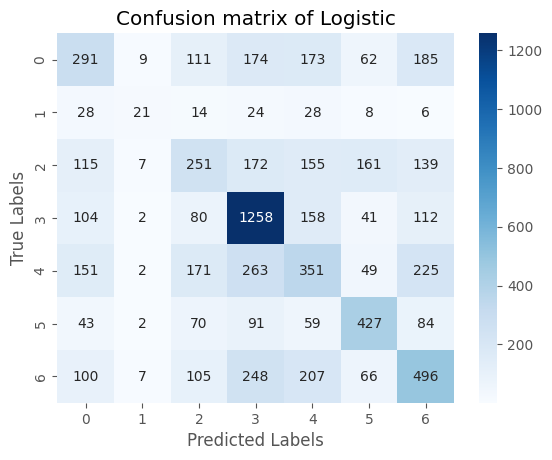

_____SVC_____
              precision    recall  f1-score   support

           0       0.46      0.39      0.42      1005
           1       0.94      0.36      0.52       129
           2       0.46      0.41      0.43      1000
           3       0.68      0.76      0.72      1755
           4       0.40      0.47      0.43      1212
           5       0.73      0.68      0.70       776
           6       0.48      0.48      0.48      1229

    accuracy                           0.54      7106
   macro avg       0.59      0.51      0.53      7106
weighted avg       0.55      0.54      0.54      7106



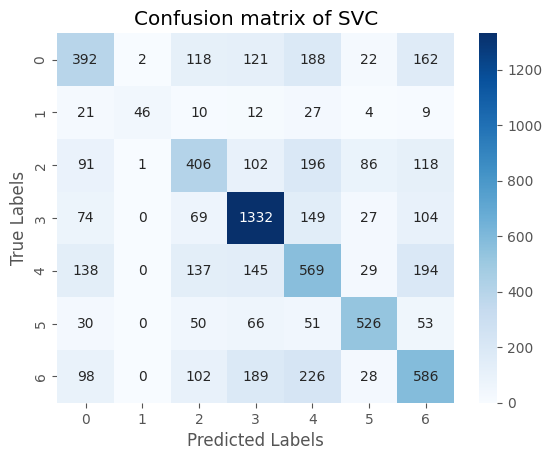

In [57]:
transform_preds = {
    "MLP": transform_mlp_preds,
    "XGB": transform_xgb_preds,
    "Logistic": transform_logreg_preds,
    "SVC": transform_svc_preds,
}

# Report of transformed predictions
for name, preds in transform_preds.items():
    print(f'_____{name}_____')
    print(classification_report(transformed_y_test, preds))
    visualize_confusion_matrix(transformed_y_test, preds, name)

Tương tự như cách giải thích ở model được train bởi Original Data, đối với trường hợp Transformed Data bằng PCA, model tốt nhất vẫn là SVC, emotion đoán đúng nhất là Label 3 (Happy), emotion đoán sai nhất là Label 4 (Sad)

### Bonus: Private Test


Ở mục này ta sẽ thử preprocessing một bức ảnh bất kỳ (không thuộc vào tập train lẫn tập test) và xem model có đoán được label của nó hay không

In [58]:
def visualize_private_test(
    images: np.ndarray, true_labels: np.ndarray, predict_labels: np.ndarray, info: str
) -> None:
    """
    Visualize the private test data (9 images)

    Args:
        images (np.ndarray): raw images
        true_labels (np.ndarray): true labels of images
        predict_labels (np.ndarray): predicted labels of images
    """

    true_labels = true_labels.ravel()
    predict_labels = predict_labels.ravel()

    fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(10, 9))
    axarr = axarr.flatten()
    colors = ["red", "green"]
    for i in range(9):
        # Randomly select an image
        idx = np.random.randint(0, len(images))

        # Plot the image
        axarr[i].imshow(images[idx], cmap="gray")
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])

        # Highlight the true and predicted labels
        axarr[i].set_title(
            f"True Label:{true_labels[idx]}\nPredict Label:{predict_labels[idx]}",
            color=colors[int(true_labels[idx] == predict_labels[idx])],
        )
    fig.tight_layout()
    print(info)
    fig.show()

In [59]:
def preprocess_private_set(
    images: np.ndarray, labels: np.ndarray, mode: str = "origin"
) -> tuple[np.ndarray, ...]:
    # Normalize
    images = images / 255.0

    # Adaptive Equalization
    with mp.Pool(processes=mp.cpu_count()) as pool:
        images = np.array(
            list((tqdm(pool.imap(adapteq_img, images)))), dtype=np.float32
        )

    # Extract features
    with mp.Pool(processes=mp.cpu_count()) as pool:
        features = np.array(
            list(tqdm(pool.imap(extract_features, images))), dtype=np.float32
        )

    # Apply PCA
    global pca_main
    if mode == "origin":
        return features, labels
    else:
        return pca_main.transform(features), labels

In [60]:
# preprocess the private test data
origin_private_set, _ = preprocess_private_set(
    private_test_images, private_test_labels
)

transform_private_set, _ = preprocess_private_set(
    private_test_images, private_test_labels, mode="transform"
)

359it [00:00, 371.78it/s]
359it [00:00, 539.14it/s]
359it [00:00, 372.25it/s]
359it [00:00, 551.08it/s]


Original phase process ........
Logistic Regression
SVC
XGBoost
MLP


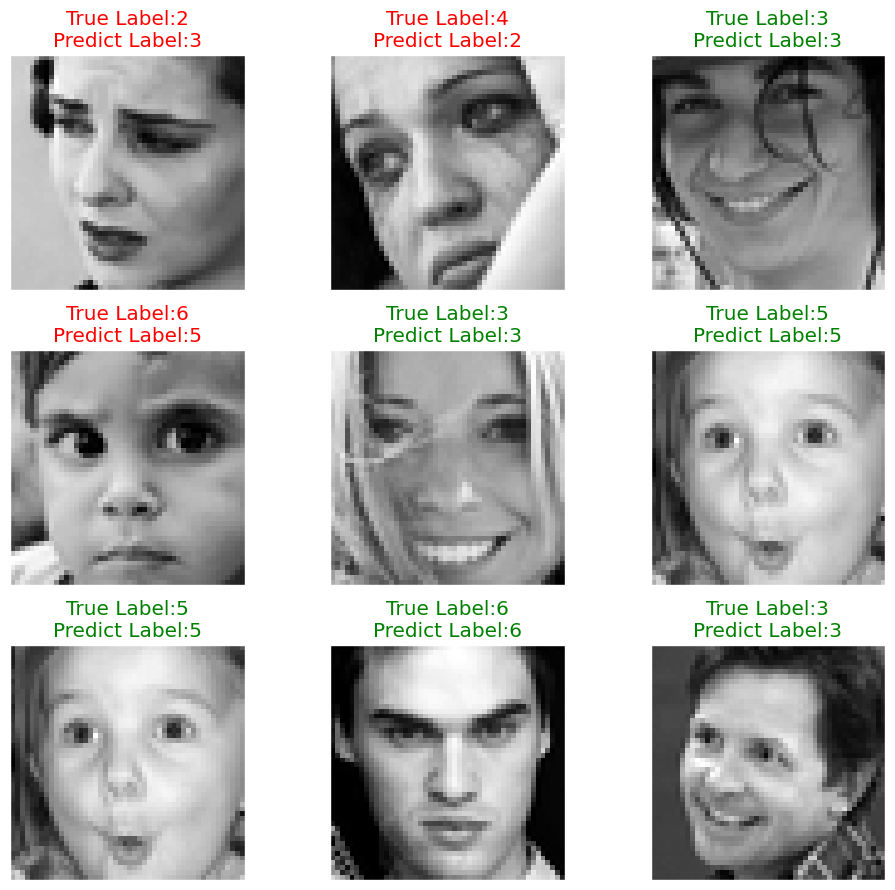

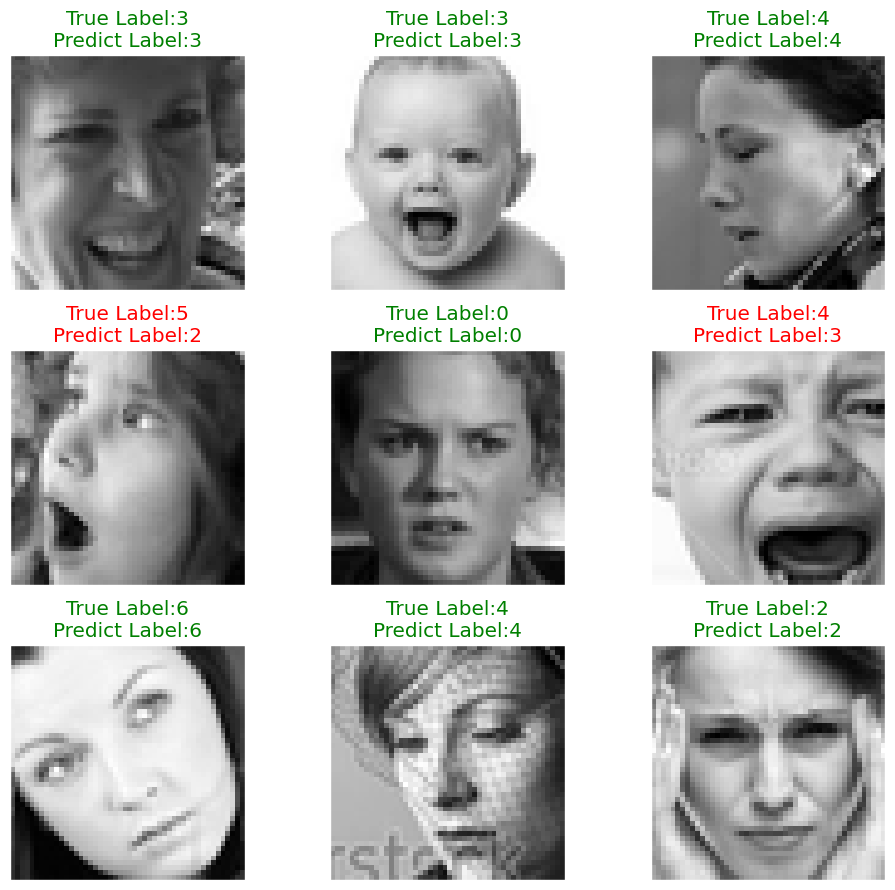

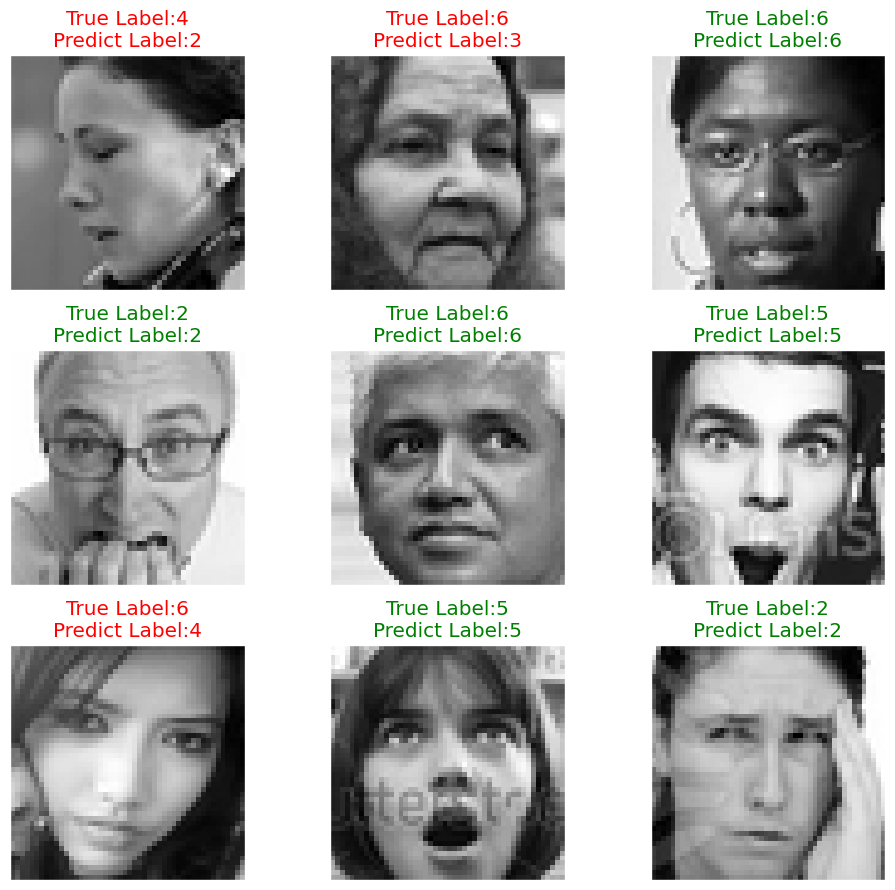

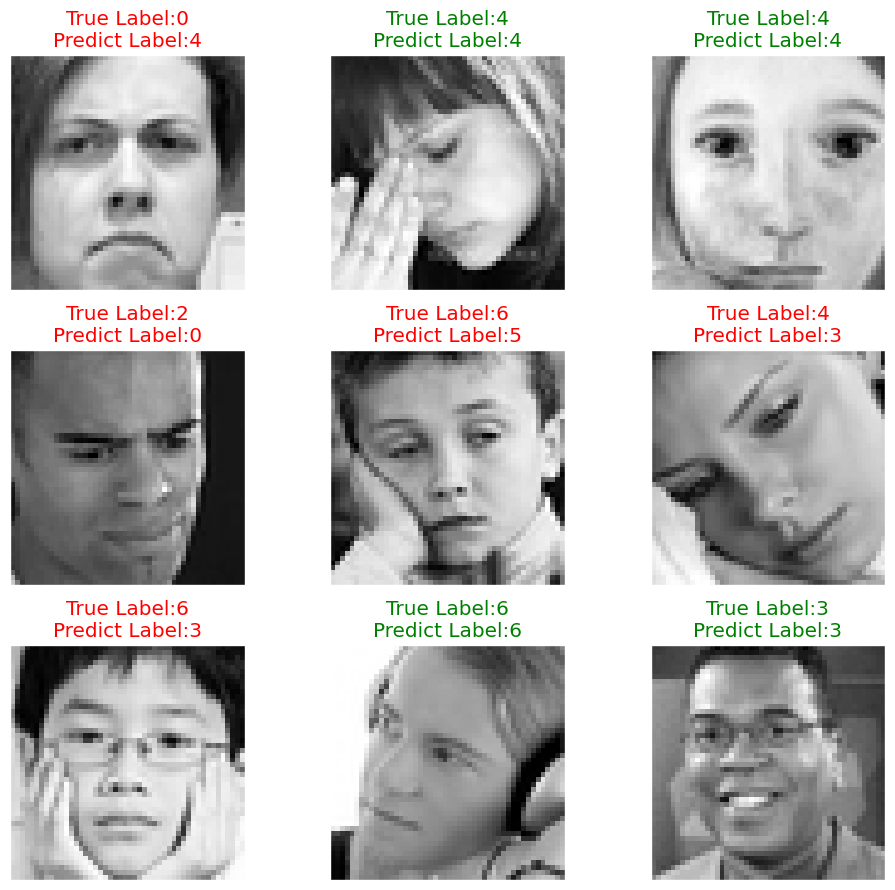

In [61]:
# visualize the private test original data
print('Original phase process ........')
origin_model_dict = {
    "Logistic Regression": origin_logreg_model,
    "SVC": origin_svc_model,
    "XGBoost": origin_xgb_model,
    "MLP": origin_mlp_model,
}
for name, model in origin_model_dict.items():
    preds = model.predict(origin_private_set)
    visualize_private_test(private_test_images, private_test_labels, preds, f'{name}')

Transformed phase process ........
Logistic Regression
SVC
XGBoost
MLP


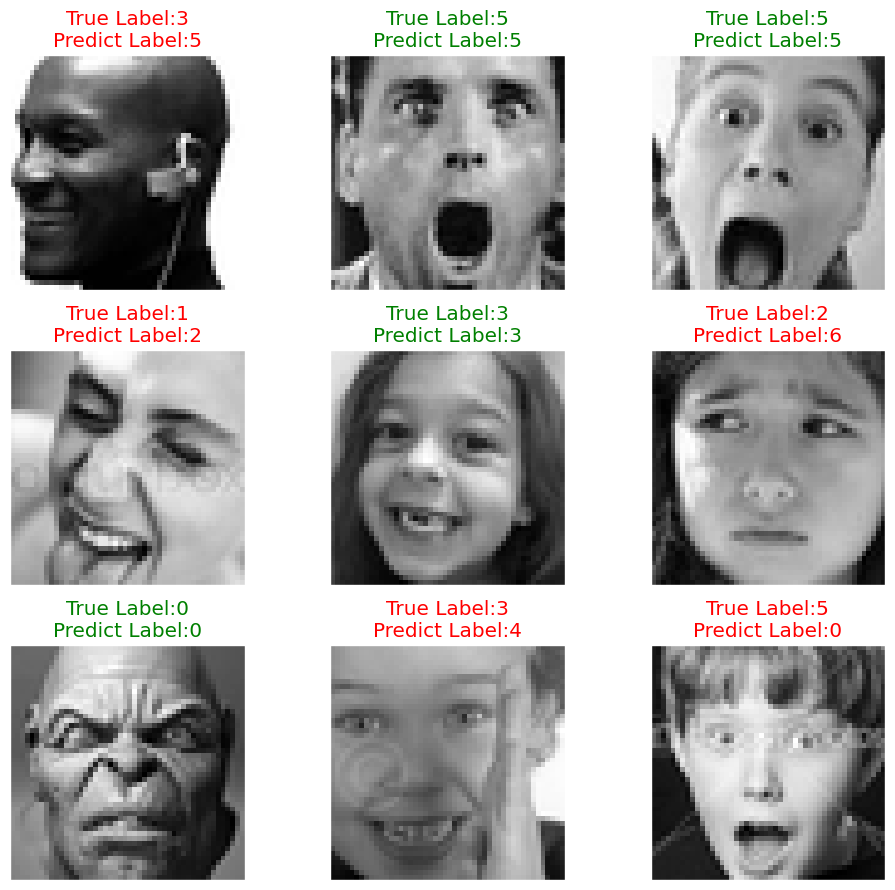

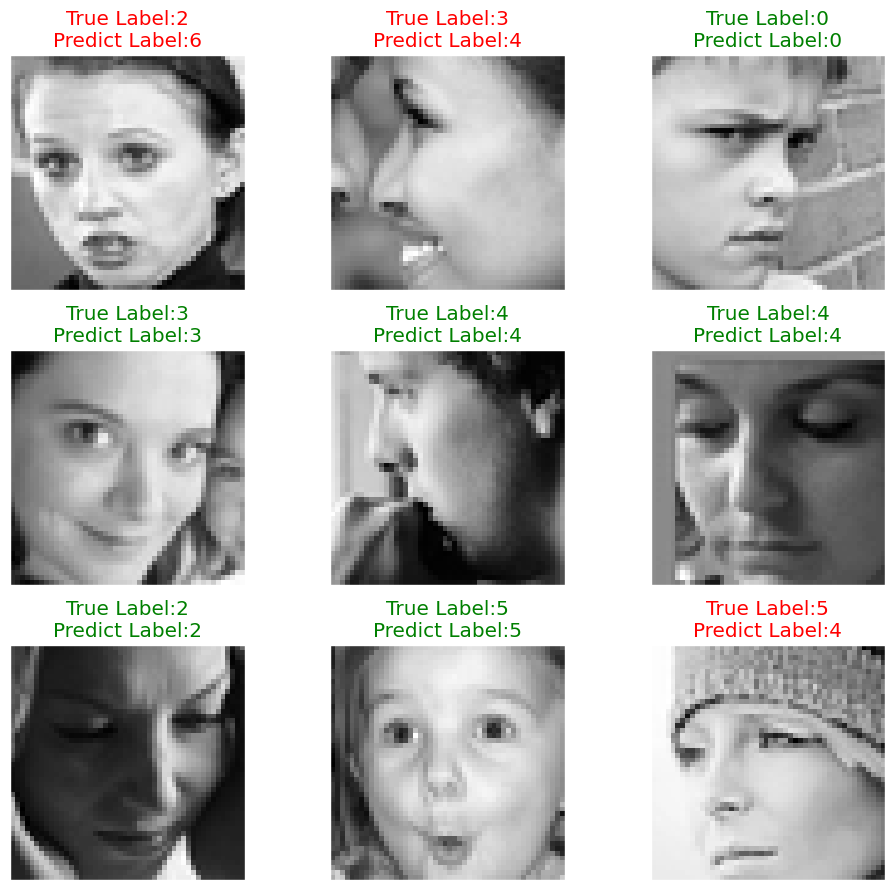

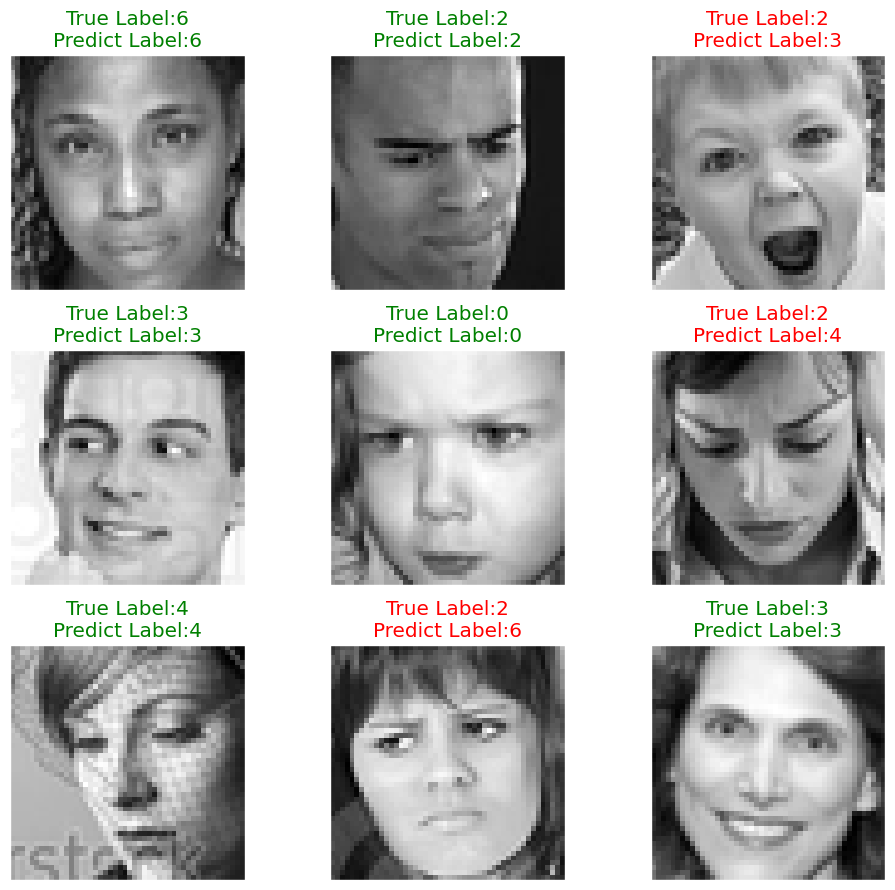

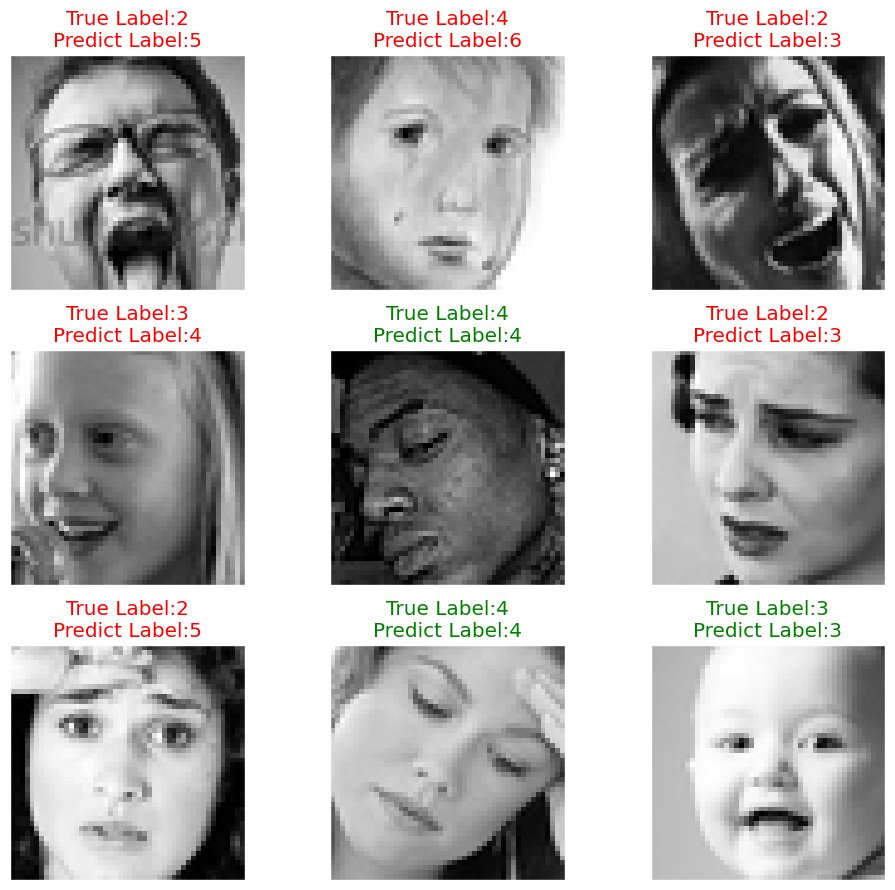

In [62]:
print('Transformed phase process ........')
transform_model_dict = {
    "Logistic Regression": transform_logreg_model,
    "SVC": transform_svc_model,
    "XGBoost": transform_xgb_model,
    "MLP": transform_mlp_model,
}
for name, model in transform_model_dict.items():
    preds = model.predict(transform_private_set)
    visualize_private_test(private_test_images, private_test_labels, preds, f'{name}')


Kết quả trả ra từ quá trình visualize thể hiện rất rõ việc model của chúng ta có số điểm F1-Score tầm 0.5 khi số dự đoán sai gần bằng với số dự đoán đúng